In [1]:
import sys
import os
import dolfyn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as dt
import xarray as xr

sys.path.append('.')

import numpy as np
import pandas as pd

import pdb

#import sedprofile.sedimentprofile as sp

%load_ext autoreload
%autoreload 2



In [2]:
baseDataFolder=r'C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data'
Stationary_ADCP_Folder=r'C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data\Tulane-LSU_2022Data\StationaryADCP'


filenameSuspD=os.path.join(baseDataFolder,r'Tulane-LSU_2022Data\Isokinetic Suspended Sediment\MR173_Grain Size Compilation.xlsx')
filenameSuspC=os.path.join(baseDataFolder,r'Tulane-LSU_2022Data\Isokinetic Suspended Sediment\MR173_Suspended Sediment Concentrations.xlsx')
filenameADCP=os.path.join(baseDataFolder,r'Tulane-LSU_2022Data\StationaryADCP\MR173_StationaryADCP&Isokinetic.xlsx')

suspCconc=pd.read_excel(filenameSuspC,index_col=0,sheet_name='Sheet1')
suspCloc=pd.read_excel(filenameSuspC,sheet_name='IsoSamplingLocs',header=None)

ADCPData=pd.read_excel(filenameADCP)

rows_to_skip=list(range(0,2))+list(range(3,82))
suspD=pd.read_excel(filenameSuspD,index_col=None,sheet_name="Sheet1",skiprows=rows_to_skip,usecols="B:FY")     

channel_diam_lower=pd.read_excel(filenameSuspD,index_col=None,sheet_name="Sheet1",skiprows=rows_to_skip,usecols="A")     

outputFolder=r"C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data\ProcessedData"

In [3]:

profile={}

#for each row in sheet IsoSamplingLocs (i.e. for each sampling location)
for i in range(0,suspCloc.shape[0]):
# for i in [0]:


    #loc = text in first column
    Location = suspCloc.at[i,0]

    #extract all rows of Sheet 1 with Location in column 2. These will become a single profile.
    filtered_rows = suspCconc[suspCconc["Station #"].fillna('').astype(str).str.contains(Location)]

    filtered_rows_ADCP = ADCPData[ADCPData["Station"].fillna('').astype(str).str.contains(Location)]

    profile[i] = {
        "station": Location,
        "QBelleChasse": -999,
        "source": "Not really sure",
        "susp_filepath": filenameSuspC,
        "datetime": filtered_rows_ADCP.iloc[0, filtered_rows_ADCP.columns.get_loc("Date & Time")],
        "lat_lon": [suspCloc.at[i,1],suspCloc.at[i,2]],
        "bed_depth_m": filtered_rows_ADCP.iloc[0, filtered_rows_ADCP.columns.get_loc("Total Depth (ft)")]*0.3048,
        "depth_frac": filtered_rows.loc[:,"Depths (0.1, 0.3, 0.5, 0.7 and 0.9H)"].values,
        "conc_sand": filtered_rows.loc[:,"Sand Conc (mg/l)"].values.T,
        "conc_mud": filtered_rows.loc[:,"Mud Conc (mg/l)"].values.T,
        "conc_total": filtered_rows.loc[:,"Total Sediment Conc (mg/l)"].values.T,
        "meas_channel_diam_lower": channel_diam_lower,
    }

    for j in range(0,profile[i]["depth_frac"].shape[0]):
#        if i==29:
#             print("debugging....")
        search_string=profile[i]["station"]+"_"+str(profile[i]["depth_frac"][j])
        measCol=suspD.filter(like=search_string)

        if j==0:
            profile[i]["meas"]=measCol.values
        else:
                profile[i]["meas"]=np.c_[profile[i]["meas"],measCol.values]

    profile[i]["meas"]=profile[i]["meas"][:,0:6]    #this is a band aid, because there should be two 0.9 values but they keep getting duplicated

    profile[i]["depth"] = profile[i]["bed_depth_m"] * profile[i]["depth_frac"]    


    # read in ADCP data
    profile[i]["ADCP_filename"]=[]
    profile[i]["ADCP_ens_start"]=[]
    profile[i]["ADCP_ens_end"]=[]
    profile[i]["ADCP_ens_start_ind"]=[]
    profile[i]["ADCP_ens_end_ind"]=[]
    profile[i]["ADCP"]=[]
    profile[i]["ADCP_t"]=[]
    profile[i]["ADCP_range"]=[]
    profile[i]["ADCP_Vmag"]=[]
    profile[i]["ADCP_Vmag_mean"]=[]
    profile[i]["ADCP_dist_bt"]=[]
    profile[i]["ADCP_dist_bt_mean"]=[]

    
    for j in range(0,filtered_rows_ADCP.shape[0]):

        if filtered_rows_ADCP.iloc[j]["Date"].date()==pd.Timestamp(2022,4,25).date():
            adcpPath=os.path.join(Stationary_ADCP_Folder,'StationaryADCP_4_25_22',filtered_rows_ADCP.iloc[j]["Stationary ADCP File Name"])

        elif filtered_rows_ADCP.iloc[j]["Date"].date()==pd.Timestamp(2022,4,26).date():
            adcpPath=os.path.join(Stationary_ADCP_Folder,'StationaryADCP_4_26_22',filtered_rows_ADCP.iloc[j]["Stationary ADCP File Name"])
        
        elif filtered_rows_ADCP.iloc[j]["Date"].date()==pd.Timestamp(2022,4,27).date():
            adcpPath=os.path.join(Stationary_ADCP_Folder,'StationaryADCP_4_27_22',filtered_rows_ADCP.iloc[j]["Stationary ADCP File Name"])
        else:
            print('DATE NOT FOUND')

        ds=dolfyn.read(adcpPath)

        profile[i]["ADCP_filename"].append(filtered_rows_ADCP.iloc[j]["Stationary ADCP File Name"])
        profile[i]["ADCP_ens_start"].append(int(filtered_rows_ADCP.iloc[j]["ADCP Ensemble Start"]))
        profile[i]["ADCP_ens_end"].append(int(filtered_rows_ADCP.iloc[j]["ADCP Ensemble End"]))

        try:
            profile[i]["ADCP_ens_start_ind"].append(np.where(ds.number.values == profile[i]["ADCP_ens_start"][j])[0].item())
            profile[i]["ADCP_ens_end_ind"].append(np.where(ds.number.values == profile[i]["ADCP_ens_end"][j])[0].item())

        except ValueError:
            print("ERROR CAUGHT. likely because of incorrect ensemble numbers in the ADCP spreadsheet")

            profile[i]["ADCP_ens_start_ind"].append(float('nan'))
            profile[i]["ADCP_ens_end_ind"].append(float('nan'))

            profile[i]["ADCP"].append(float('nan'))
            profile[i]["ADCP_t"].append(float('nan'))
            profile[i]["ADCP_range"].append(float('nan'))
            profile[i]["ADCP_Vmag"].append(float('nan'))
            profile[i]["ADCP_Vmag_mean"].append(float('nan'))
            profile[i]["ADCP_dist_bt"].append(float('nan'))

        else:
            t = dolfyn.time.dt642date(ds.time)

            # V1=ds['vel']
            # V2=ds['vel']-ds['vel_bt']
            # V3=np.linalg.norm(V2,axis=0)

            # dd=ds['prcnt_gd'].sum(dim='beam')

            # Calculate the mean distance for each time
            mean_dist = ds["dist_bt"].mean(dim=["beam"])

            # Create a boolean mask where the condition is true
            mask = mean_dist > ds["range"]
            V_masked=ds["vel"].where(mask, np.nan)
            V_mag=np.linalg.norm(V_masked,axis=0)

            profile[i]["ADCP"].append(ds)
            profile[i]["ADCP_t"].append(
                t[
                profile[i]["ADCP_ens_start_ind"][j]:
                profile[i]["ADCP_ens_end_ind"][j]
                ])
            profile[i]["ADCP_range"].append(ds["range"])
            profile[i]["ADCP_Vmag"].append(
                V_mag[
                :,
                profile[i]["ADCP_ens_start_ind"][j]:profile[i]["ADCP_ens_end_ind"][j]
                ])
            profile[i]["ADCP_Vmag_mean"].append(np.nanmean(profile[i]["ADCP_Vmag"][j],axis=1))
            
            profile[i]["ADCP_dist_bt"].append(mean_dist[
                profile[i]["ADCP_ens_start_ind"][j]:
                profile[i]["ADCP_ens_end_ind"][j]
            ])






Reading file C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data\Tulane-LSU_2022Data\StationaryADCP\StationaryADCP_4_27_22\DeltaDay3_019_22-04-27_143107.PD0 ...

Reading file C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data\Tulane-LSU_2022Data\StationaryADCP\StationaryADCP_4_27_22\DeltaDay3_019_22-04-27_143107.PD0 ...

Reading file C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data\Tulane-LSU_2022Data\StationaryADCP\StationaryADCP_4_27_22\DeltaDay3_019_22-04-27_143107.PD0 ...

Reading file C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data\Tulane-LSU_2022Data\StationaryADCP\StationaryADCP_4_27_22\DeltaDay3_019_22-04-27_143107.PD0 ...

Reading file C:\Users\cesposito\The Water Institute of the Gulf\P-00703_NSF_Caltech - General\Data\Tulane-LSU_2022Data\StationaryADCP\StationaryADCP_4_27_22\DeltaDay3_019_22-04-27_143107.PD0 ...

Reading file C:\Use

ValueError: For X (0) and Y (45) with flat shading, A should have shape (44, -1, 3) or (44, -1, 4) or (44, -1) or (-44,), not (0,)

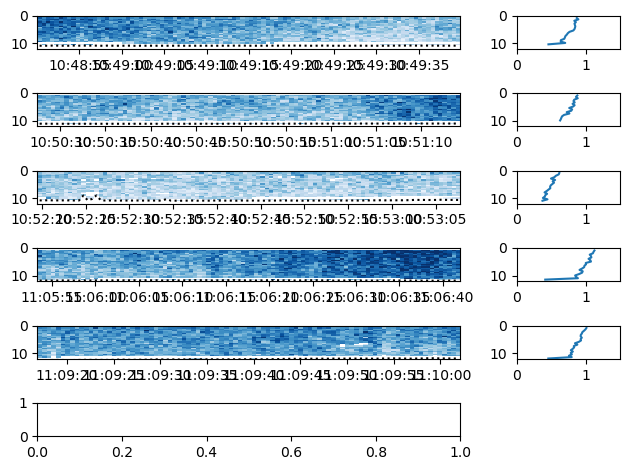

In [31]:
plt.close('all')

#velocity profiles 

for i in range(0,len(profile)):
    numADCP=len(profile[i]["ADCP"])

    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(numADCP, 4)

    for j in range(0,numADCP):

        ax = fig.add_subplot(gs[j,0:3])
        if type(profile[i]["ADCP_t"][j])!=float:
            pcm = ax.pcolormesh(
                profile[i]["ADCP_t"][j], 
                profile[i]["ADCP_range"][j], 
                profile[i]["ADCP_Vmag"][j], 
                cmap='Blues', shading='nearest'
                )
            pcm.set_clim([0, 1.5])
            ax.plot(
                profile[i]["ADCP_t"][j],
                profile[i]["ADCP_dist_bt"][j]
                ,'k:'
                )
            ax.set_ylim([12, 0])

        ax = fig.add_subplot(gs[j,3])
        if type(profile[i]["ADCP_t"][j])!=float:
            ax.plot(profile[i]["ADCP_Vmag_mean"][j],profile[i]["ADCP_range"][j])
            ax.set_ylim([12, 0])
            ax.set_xlim([0, 1.5])


    
    FigTitle=profile[i]["station"]+"\n"+"Q Belle Chasse: "+str(profile[i]["QBelleChasse"])+"\n"+str(profile[i]["datetime"])+"\n"+"bed depth (m): "+str(profile[i]["bed_depth_m"])

    fig.suptitle(FigTitle)

    filename = "ADCP_"+profile[i]["station"]+"_"+str(profile[i]["datetime"])+".png"
    illegal_chars = {'<', '>', ':', '"', '/', '\\', '|', '?', '*'}
    sanitized_filename = ''.join(c if c not in illegal_chars else '_' for c in filename)

    fig.savefig(os.path.join(outputFolder, sanitized_filename))
    
    plt.close(fig)  # Close the figure to free up resources

In [ ]:
plt.close('all')

for i in range(0,len(profile)):

    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(3, 3)

    ylims=[0-0.1*profile[i]["bed_depth_m"],1.1*profile[i]["bed_depth_m"]]

    ax = fig.add_subplot(gs[0:1,0])
    ax.scatter(profile[i]["conc_sand"],profile[i]["bed_depth_m"]-profile[i]["depth"])
    ax.plot([0, 9999], [0, 0],
        linestyle='--', linewidth=2, color='black')
    ax.set_ylabel('height above bed (m)')
    ax.set_xlabel('sand (mg/L)')
    ax.set_ylim(ylims)
    ax.set_xlim(-5,100)

    ax = fig.add_subplot(gs[0:1,1])
    ax.scatter(profile[i]["conc_mud"],profile[i]["bed_depth_m"]-profile[i]["depth"])
    ax.plot([0, 9999], [0, 0],
        linestyle='--', linewidth=2, color='black')
    ax.set_xlabel('mud (mg/L)')
    ax.set_ylim(ylims)
    ax.set_xlim(-10,250)

    ax = fig.add_subplot(gs[0:1,2])
    for j in range(0,numADCP):
        ax.plot(profile[i]["ADCP_Vmag_mean"][j],profile[i]["bed_depth_m"]-profile[i]["ADCP_range"][j])
        ax.plot([0, 9999], [0, 0],
            linestyle='--', linewidth=2, color='black')
        ax.set_ylim(ylims)
        ax.set_xlim([0, 1.5])
        #ax.plot([0, 9999], [0, 0],
        #    linestyle='--', linewidth=2, color='black')
        #ax.set_xlabel('Velocity (m/s)')
        #ax.set_ylim(ylims)
        #ax.set_xlim(-0.5,3)

    ax = fig.add_subplot(gs[1,0:3])
    ax.set_xlabel(r'$\mu$m')
    ax.set_ylabel("Volume %")
    
    for j in range(profile[i]["meas"].shape[1]):
        labelText=profile[i]["depth_frac"][j]
        try:
            ax.semilogx(profile[i]["meas_channel_diam_lower"],profile[i]["meas"][:,j],label=labelText)
        except Exception as e:
            print("An error occurred:", e)
            print('...continuing from error....')

    ax.legend(fontsize = 'x-small')

    FigTitle=profile[i]["station"]+"\n"+"Q Belle Chasse: "+str(profile[i]["QBelleChasse"])+"\n"+str(profile[i]["datetime"])+"\n"+"bed depth (m): "+str(profile[i]["bed_depth_m"])

    fig.suptitle(FigTitle)

    filename = profile[i]["station"]+"_"+str(profile[i]["datetime"])+".png"
    illegal_chars = {'<', '>', ':', '"', '/', '\\', '|', '?', '*'}
    sanitized_filename = ''.join(c if c not in illegal_chars else '_' for c in filename)

    fig.savefig(os.path.join(outputFolder, sanitized_filename))

    plt.close(fig)  # Close the figure to free up resources


In [39]:
# pcm = ax.pcolormesh(
#     profile[i]["ADCP_t"][j], 
#     profile[i]["ADCP_range"][j], 
#     profile[i]["ADCP_Vmag"][j], 
#     cmap='Blues', shading='nearest'
#     )


# profile[i]["ADCP_t"][j]
# profile[i]["ADCP_range"][j]
# profile[i]["ADCP_Vmag"][j] 

print(i,j)

8 5
